In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from PIL import Image
import os

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns


In [2]:


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        
        self.samples = sorted(os.listdir(root_dir))

        
        self.class_to_label = {}
        label_counter = 0

        for sample_name in self.samples:
            if sample_name.startswith("Sample") and label_counter <= 61:
                label = label_counter
                

            self.class_to_label[sample_name] = label
            label_counter += 1

       
        self.file_paths = []
        self.labels = []

      
        for sample_name in self.samples:
            sample_path = os.path.join(root_dir, sample_name)
            label = self.class_to_label[sample_name]
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                self.file_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]


        return image, label

    def remove_item(self, index):
        self.file_paths.pop(index)
        self.labels.pop(index)


In [3]:
root_folder = "datast"
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                ])

custom_dataset = CustomDataset(root_folder, transform=transform)

sample_image, sample_label = custom_dataset[54000]

In [4]:
train_image, test_image, train_labels, test_labels = train_test_split(
    custom_dataset.file_paths,
    custom_dataset.labels,
    test_size = 0.2,
    random_state=42
)

train_dataset = CustomDataset(root_dir=root_folder, transform=transform)
train_dataset.file_paths = train_image
train_dataset.labels = train_labels

test_dataset = CustomDataset(root_dir=root_folder, transform=transform)
test_dataset.file_paths = test_image
test_dataset.labels = test_labels


batch_size = 32
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

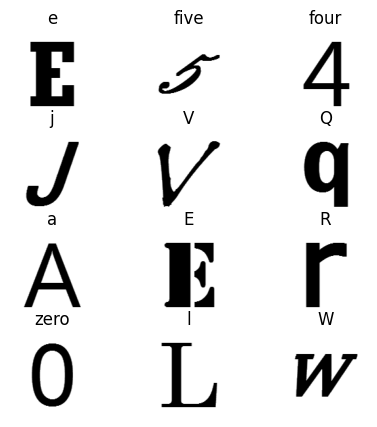

In [5]:
labels_map = {
    
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine',
    10: 'a',
    11: 'b',
    12: 'c',
    13: 'd',
    14: 'e',
    15: 'f',
    16: 'g',
    17: 'h',
    18: 'i',
    19: 'j',
    20: 'k',
    21: 'l',
    22: 'm',
    23: 'n',
    24: 'o',
    25: 'p',
    26: 'q',
    27: 'r',
    28: 's',
    29: 't',
    30: 'u',
    31: 'v',
    32: 'w',
    33: 'x',
    34: 'y',
    35: 'z',
    36: 'A',
    37: 'B',
    38: 'C',
    39: 'D',
    40: 'E',
    41: 'F',
    42: 'G',
    43: 'H',
    44: 'I',
    45: 'J',
    46: 'K',
    47: 'L',
    48: 'M',
    49: 'N',
    50: 'O',
    51: 'P',
    52: 'Q',
    53: 'R',
    54: 'S',
    55: 'T',
    56: 'U',
    57: 'V',
    58: 'W',
    59: 'X',
    60: 'Y',
    61: 'Z',

}

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(custom_dataset), size=(1,)).item()
    img, label = custom_dataset[sample_idx]
    
    img = img.permute(1, 2, 0)
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
    
plt.show()

In [6]:
class OCRNN(nn.Module):
    def __init__(self):
        super(OCRNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_input_size = self.calculate_fc_input_size()

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(self.fc_input_size, 62)  


    def forward(self, x):
        x = self.layers(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)

        return x

    def calculate_fc_input_size(self):
        dummy_input = torch.randn((1, 3, 128, 128))
        dummy_output = self.layers(dummy_input)
        return dummy_output.view(dummy_output.size(0), -1).size(1)

In [7]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print(f"GPU (CUDA) is available. Using GPU {torch.cuda.current_device()}.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU (CUDA) is available. Using GPU 0.


In [8]:
model = OCRNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/10, Loss: 0.632925808429718
Epoch 2/10, Loss: 0.9464740753173828
Epoch 3/10, Loss: 0.4236926734447479
Epoch 4/10, Loss: 0.5482785701751709
Epoch 5/10, Loss: 0.4888429641723633
Epoch 6/10, Loss: 0.42973244190216064
Epoch 7/10, Loss: 0.3703417181968689
Epoch 8/10, Loss: 0.0996432974934578
Epoch 9/10, Loss: 0.18688374757766724
Epoch 10/10, Loss: 0.7669675946235657


In [9]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

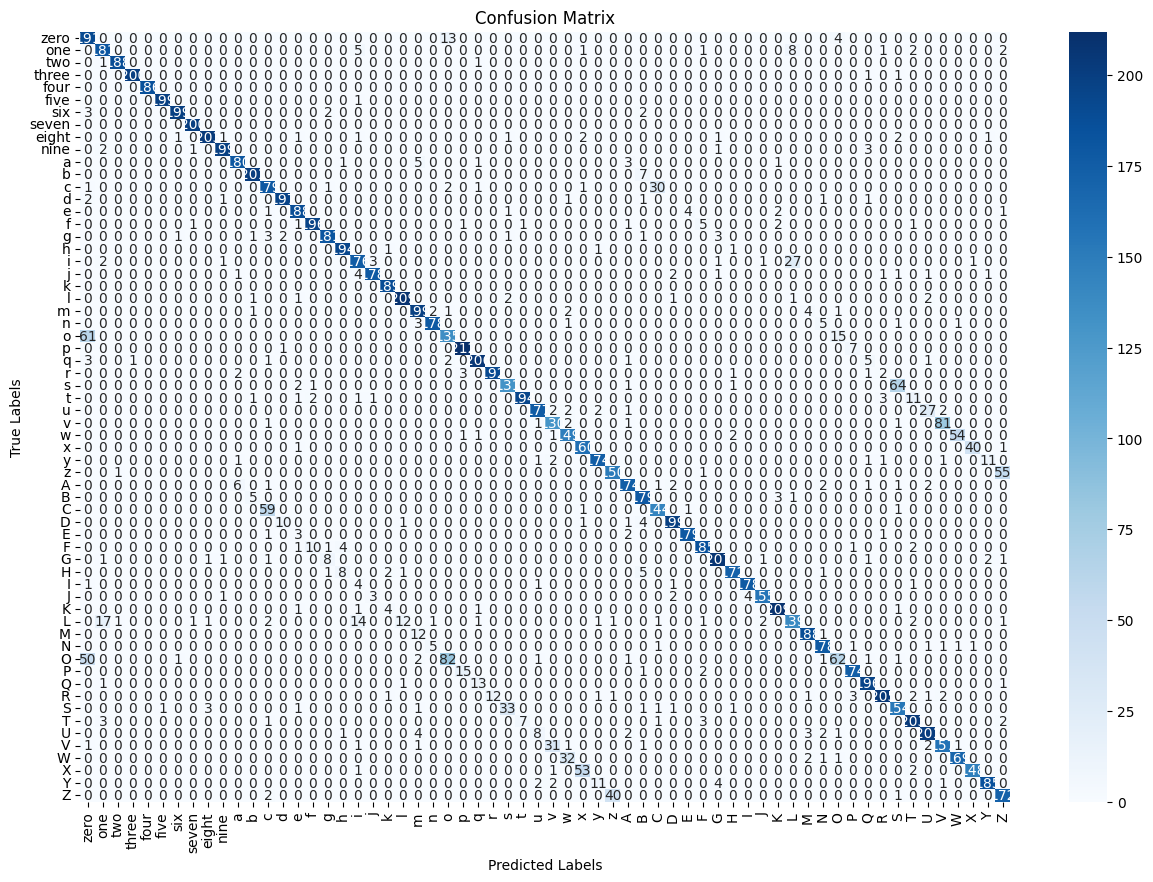

In [10]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [15]:
accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 88.21%
